<div style="text-align: center; font-size: 40px; font-weight: bold;">
    Train Model U-Net Architecture
</div>

# Libraries

In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
import tensorflow.keras.backend as K
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from skimage.transform import resize
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


Segmentation Models: using `tf.keras` framework.


# Functions

In [2]:
def map_mask_to_classes(mask_array: np.ndarray) -> np.ndarray:
    """
    Maps a binary mask to class labels.
    
    Args:
        mask_array (np.ndarray): Input mask array.
        
    Returns:
        np.ndarray: Binary mask with values mapped to 0 and 1.
    """
    return (mask_array > 0).astype(np.uint8)

In [3]:
def load_images_and_masks(image_folder: str, mask_folder: str, img_height: int, img_width: int) -> tuple:
    """
    Loads images and masks from specified folders, normalizes images, and processes masks.
    
    Args:
        image_folder (str): Path to the image folder.
        mask_folder (str): Path to the mask folder.
        img_height (int): Target image height.
        img_width (int): Target image width.
        
    Returns:
        tuple: (numpy.ndarray of images, numpy.ndarray of masks)
    """
    images, masks = [], []
    
    image_files = sorted(os.listdir(image_folder))
    mask_files = sorted(os.listdir(mask_folder))
    
    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_folder, img_file)
        mask_path = os.path.join(mask_folder, mask_file)
        
        # Load and normalize image
        img = load_img(img_path, target_size=(img_height, img_width))
        img = img_to_array(img) / 255.0
        images.append(img)
        
        # Load and process mask
        mask = load_img(mask_path, target_size=(img_height, img_width), color_mode="grayscale")
        mask = img_to_array(mask).astype(np.int32).squeeze()
        masks.append(map_mask_to_classes(mask))
    
    return np.array(images), np.array(masks).reshape(-1, img_height, img_width, 1)


In [ ]:
IMG_HEIGHT, IMG_WIDTH = 512, 512 
def unet_model(input_size: tuple = (IMG_HEIGHT, IMG_WIDTH, 3)) -> Model:
    """
    Builds a U-Net model for image segmentation.
    
    Args:
        input_size (tuple): Shape of the input image.
        
    Returns:
        Model: Compiled U-Net model.
    """
    inputs = Input(input_size)
    
    # Encoder
    def conv_block(x, filters):
        x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        return x
    
    c1 = conv_block(inputs, 16)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = conv_block(p1, 32)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = conv_block(p2, 64)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = conv_block(p3, 128)
    p4 = MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    c5 = conv_block(p4, 256)
    
    # Decoder
    def upsample_block(x, skip, filters):
        x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)
        x = concatenate([x, skip])
        x = conv_block(x, filters)
        return x
    
    c6 = upsample_block(c5, c4, 128)
    c7 = upsample_block(c6, c3, 64)
    c8 = upsample_block(c7, c2, 32)
    c9 = upsample_block(c8, c1, 16)
    
    # Output layer with sigmoid activation
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    return Model(inputs, outputs)

In [5]:
def iou_metric(y_true, y_pred, smooth: float = 1e-6) -> float:
    """
    Computes the Intersection over Union (IoU) metric.
    
    Args:
        y_true: Ground truth binary mask.
        y_pred: Predicted binary mask.
        smooth (float): Smoothing factor to avoid division by zero.
    
    Returns:
        float: IoU score.
    """
    y_pred = K.cast(y_pred > 0.5, dtype='float32')
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

In [6]:
def dice_loss(y_true, y_pred, smooth: float = 1e-6) -> tf.Tensor:
    """
    Computes the Dice loss for image segmentation.
    
    Args:
        y_true: Ground truth binary mask.
        y_pred: Predicted mask.
        smooth (float): Smoothing factor to avoid division by zero.
    
    Returns:
        tf.Tensor: Dice loss value.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    return 1 - ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

# Load Images

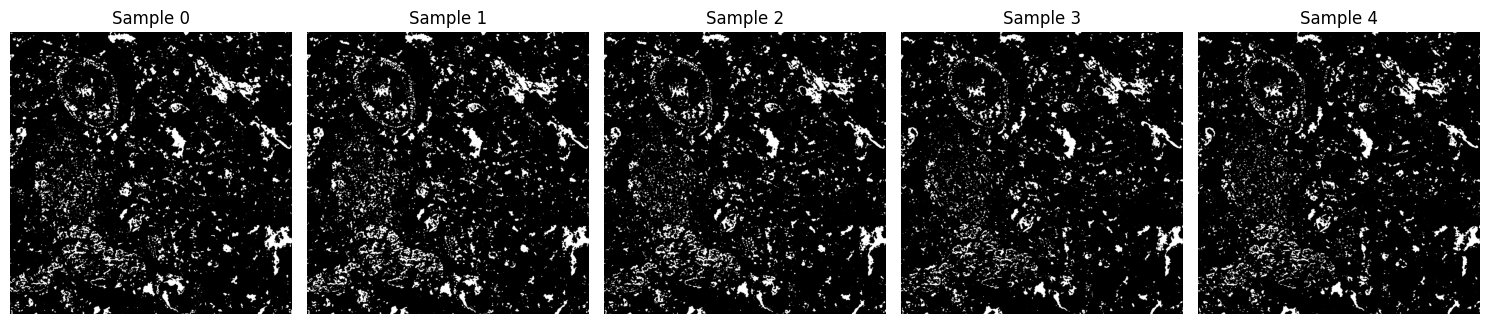

In [7]:
# Folder path
folder_path = "Data_mask"

# Sorted images
image_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".bmp")])

# Select the first five images
selected_images = image_files[:5]

# Show images for horizontal structure form
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

# Looping to call the images
for i, img_name in enumerate(selected_images):
    img_path = os.path.join(folder_path, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

    axes[i].imshow(img, cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"Sample {i}")

# Plot the images
plt.tight_layout()
plt.show()

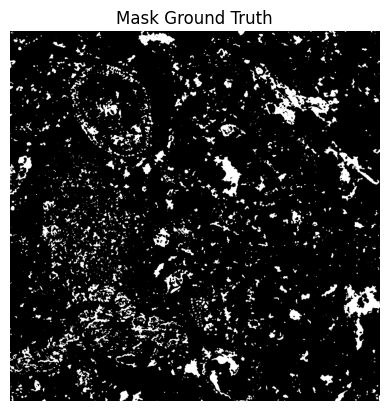

Unique value form masking image: [  0 255]


In [8]:
mask_path = "Data_mask/mask_CLAHE_dlm0000.bmp"
mask = Image.open(mask_path)
plt.imshow(mask, cmap='gray')
plt.title("Mask Ground Truth")
plt.axis('off')
plt.show()

# Check unique value on the mask
mask_array = np.array(mask)
print(f"Unique value form masking image: {np.unique(mask_array)}")

# Splitting Dataset

In [9]:
# Load dataset train and validation
train_images, train_masks = load_images_and_masks('Data_split/train/images', 'Data_split/train/masks', IMG_HEIGHT, IMG_WIDTH)
val_images, val_masks = load_images_and_masks('Data_split/valid/images', 'Data_split/valid/masks', IMG_HEIGHT, IMG_WIDTH)

print(f"Shape train_images: {train_images.shape}")
print(f"Shape train_masks: {train_masks.shape}")

Shape train_images: (595, 512, 512, 3)
Shape train_masks: (595, 512, 512, 1)


In [10]:
# Buat model
model = unet_model()

# Kompilasi model
# ======= Kompilasi Model =======
model.compile(optimizer='adam',
              loss=dice_loss,
              metrics=['accuracy', iou_metric])

# ======= Callbacks =======
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

lr_reduce = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.5, 
                              patience=5, 
                              min_lr=1e-6,
                              verbose=1)

model_checkpoint = ModelCheckpoint('Model/model.h5', 
                                   monitor='val_loss', 
                                   save_best_only=True, 
                                   verbose=1)

callbacks = [early_stop, lr_reduce, model_checkpoint]
# ======= Training Contoh =======
history = model.fit(train_images, train_masks,
                    validation_data=(val_images, val_masks),
                    epochs=100,
                    callbacks=callbacks)

2025-04-02 13:23:37.075209: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-04-02 13:23:37.075339: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-02 13:23:37.075515: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-02 13:23:37.076352: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-02 13:23:37.076998: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2025-04-02 13:23:40.978578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - ETA: 0s - loss: 0.8029 - accuracy: 0.8760 - iou_metric: 0.3243

2025-04-02 13:26:15.018896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.70967, saving model to Model/model.h5
19/19 [==============================] - 157s 8s/step - loss: 0.8029 - accuracy: 0.8760 - iou_metric: 0.3243 - val_loss: 0.7097 - val_accuracy: 0.9093 - val_iou_metric: 0.4925 - lr: 0.0010
Epoch 2/100


/Users/muhammadreesarosyid/tensorflow-test/env/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/19 [==============================] - ETA: 0s - loss: 0.5891 - accuracy: 0.8638 - iou_metric: 0.3634
Epoch 2: val_loss improved from 0.70967 to 0.39825, saving model to Model/model.h5
19/19 [==============================] - 161s 8s/step - loss: 0.5891 - accuracy: 0.8638 - iou_metric: 0.3634 - val_loss: 0.3982 - val_accuracy: 0.9418 - val_iou_metric: 0.5067 - lr: 0.0010
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.4102 - accuracy: 0.9234 - iou_metric: 0.4651
Epoch 3: val_loss improved from 0.39825 to 0.35085, saving model to Model/model.h5
19/19 [==============================] - 143s 7s/step - loss: 0.4102 - accuracy: 0.9234 - iou_metric: 0.4651 - val_loss: 0.3508 - val_accuracy: 0.9426 - val_iou_metric: 0.5056 - lr: 0.0010
Epoch 4/100
19/19 [==============================] - ETA: 0s - loss: 0.3250 - accuracy: 0.9393 - iou_metric: 0.5444
Epoch 4: val_loss improved from 0.35085 to 0.30126, saving model to Model/model.h5
19/19 [==============================

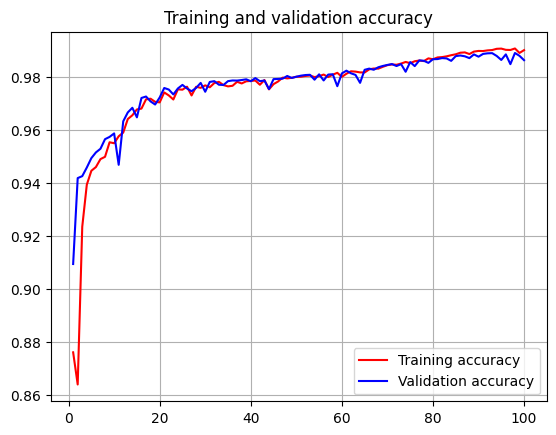

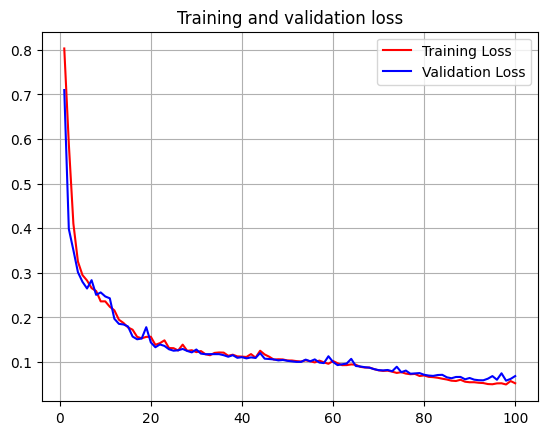

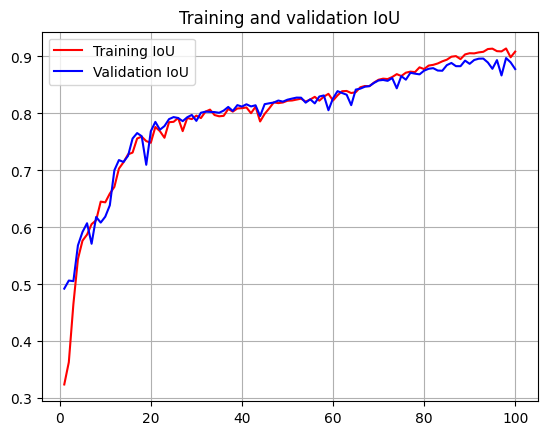

In [11]:
# Extract data from history.history
epochs = range(1, len(history.history['loss']) + 1)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
iou = history.history['iou_metric']
val_iou = history.history['val_iou_metric']

# Plotting Training and Validation Accuracy
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.grid(True)
plt.show()  # Display accuracy plot

# Plotting Training and Validation Loss
plt.figure()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid(True)
plt.show()  # Display loss plot

# Plotting Training and Validation IoU
plt.figure()
plt.plot(epochs, iou, 'r', label='Training IoU')
plt.plot(epochs, val_iou, 'b', label='Validation IoU')
plt.title('Training and validation IoU')
plt.legend()
plt.grid(True)
plt.show()  # Display IoU plot